In [2]:
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.calibration import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import KernelPCA
from skmatter.decomposition import PCovC
from skmatter.decomposition._kernel_pcovc_linear import KernelPCovC
from matplotlib.colors import ListedColormap
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import matplotlib as mpl

plt.rcParams["scatter.edgecolors"] = "k"
cm_bright = ListedColormap(["#d7191c", "#fdae61", "#a6d96a", "#3a7cdf"])

random_state = 0
n_components = 2

In [3]:
X1, y1 = datasets.make_moons(n_samples=1000, noise=0.1, random_state=random_state)
X2, y2 = datasets.make_moons(n_samples=1000, noise=0.1, random_state=random_state)

# Shift X2 outward so it doesn’t sit directly on X1
X2, y2 = X2 * 2 + 2, y2 + 2

R = np.array(
    [
        [np.cos(np.pi / 2), -np.sin(np.pi / 2)],
        [np.sin(np.pi / 2), np.cos(np.pi / 2)],
    ]
)
X2 = X2 @ R.T

X = np.vstack([X1, X2])
y = np.concatenate([y1, y2])

## Original Data

Text(0.5, 1.0, 'Original Data')

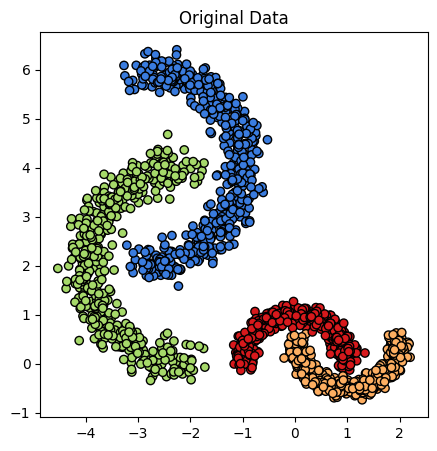

In [4]:
fig, axis = plt.subplots(figsize=(5, 5))
axis.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright)
axis.set_title("Original Data")

### Scale data:

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=random_state
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## PCA and PCovC

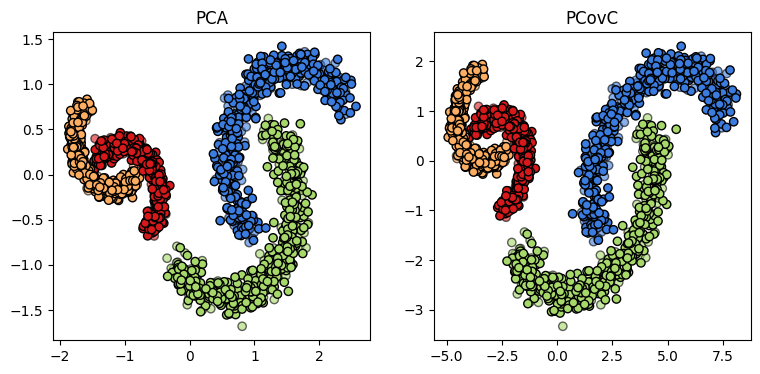

In [6]:
from sklearn.inspection import DecisionBoundaryDisplay

models = {
    PCA(n_components=n_components): "PCA",
    PCovC(
        n_components=n_components,
        random_state=random_state,
        mixing=0.10,
        classifier=LinearSVC(),
    ): "PCovC",
}

fig, axes = plt.subplots(1, 2, figsize=(9, 4))

for i, model in enumerate(models):
    t_train = (
        model.fit_transform(X_train_scaled)
        if isinstance(model, PCA)
        else model.fit_transform(X_train_scaled, y_train)
    )
    t_test = model.transform(X_test_scaled)
    axes[i].scatter(t_test[:, 0], t_test[:, 1], alpha=0.6, cmap=cm_bright, c=y_test)

    axes[i].scatter(t_train[:, 0], t_train[:, 1], cmap=cm_bright, c=y_train)
    axes[i].set_title(models[model])

## KPCA and KPCovC

Kernel PCA Kernel Params:{'gamma': 15, 'degree': 3, 'coef0': 1}
Kernel PCA Kernel Params:{'gamma': 15, 'degree': 3, 'coef0': 1}
KernelPCA Kernel: [-0.01266753 -0.05011555 -0.00135064  0.47201955 -0.04859363]
KPCA Eigenvalues: [89.35703408 82.54704583]


Text(0.5, 1.0, 'Kernel PCovC')

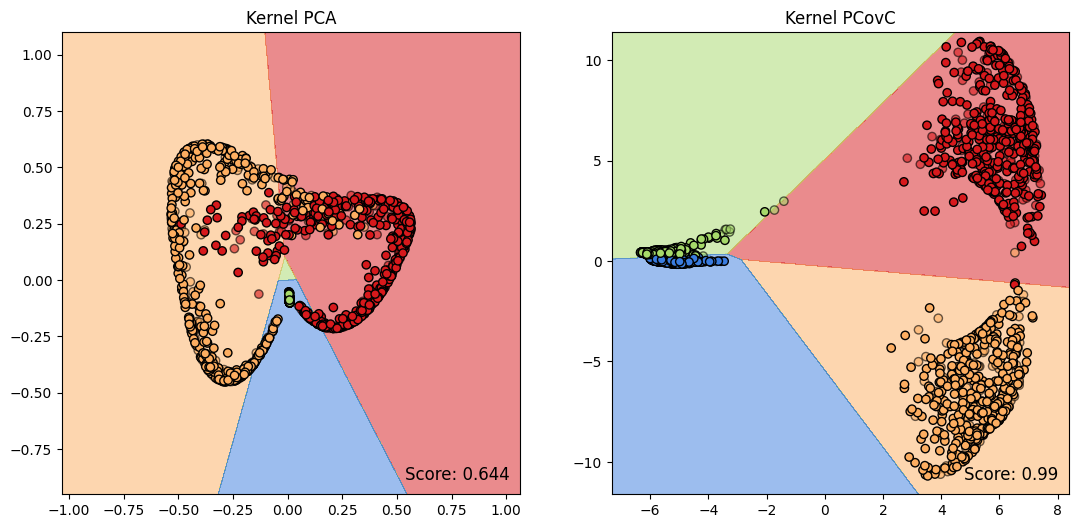

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(13, 6))

kernel_params = {"kernel": "rbf", "gamma": 15}

kpca = KernelPCA(n_components=n_components, **kernel_params)

kpcovc = KernelPCovC(
    n_components=n_components,
    classifier=LogisticRegression(),
    random_state=random_state,
    mixing=0.1,
    gamma=5,
    center=True,
    kernel="rbf"
)

t_kpca_train = kpca.fit_transform(X_train_scaled)
t_kpca_test = kpca.transform(X_test_scaled)

t_kpcovc_train = kpcovc.fit_transform(X_train_scaled, y_train)
t_kpcovc_test = kpcovc.transform(X_test_scaled)

kpca_classifier = LinearSVC(random_state=random_state).fit(
    t_kpca_train, y_train
)

kpca_score = kpca_classifier.score(t_kpca_test, y_test)
kpcovc_score = kpcovc.score(X_test_scaled, y_test)

DecisionBoundaryDisplay.from_estimator(
    estimator=kpca_classifier,
    X=t_kpca_test,
    ax=axes[0],
    response_method="predict",
    eps=0.5,
    cmap=cm_bright,
    alpha=0.5,
    grid_resolution=1500,
)
DecisionBoundaryDisplay.from_estimator(
    estimator=kpcovc.classifier_,
    X=t_kpcovc_test,
    ax=axes[1],
    response_method="predict",
    cmap=cm_bright,
    alpha=0.5,
    grid_resolution=1500,
)

axes[0].scatter(
    t_kpca_test[:, 0], t_kpca_test[:, 1], alpha=0.6, cmap=cm_bright, c=y_test
)
axes[0].scatter(t_kpca_train[:, 0], t_kpca_train[:, 1], cmap=cm_bright, c=y_train)
axes[0].set_title("Kernel PCA")
axes[0].text(
    0.75,
    0.03,
    f"Score: {round(kpca_score, 3)}",
    fontsize=mpl.rcParams["axes.titlesize"],
    transform=axes[0].transAxes,
)

axes[1].scatter(
    t_kpcovc_test[:, 0], t_kpcovc_test[:, 1], cmap=cm_bright, alpha=0.6, c=y_test
)
axes[1].scatter(t_kpcovc_train[:, 0], t_kpcovc_train[:, 1], cmap=cm_bright, c=y_train)

axes[1].text(
    0.77,
    0.03,
    f"Score: {round(kpcovc_score, 3)}",
    fontsize=mpl.rcParams["axes.titlesize"],
    transform=axes[1].transAxes,
)
# axes[1].set_xlim(t_kpcovc_train[:, 0].min() - 1, t_kpcovc_train[:, 0].max() + 0.50)
# axes[1].set_ylim(t_kpcovc_train[:, 1].min() - 0.25, t_kpcovc_train[:, 1].max() + 0.25)

axes[1].set_title("Kernel PCovC")